In [11]:
from __future__ import print_function
import os
import os.path
import numpy as np
from dataIO import pk
import torch.utils.data as data
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from time import time
from PIL import Image
import torchvision.models as models

In [12]:
class Feline(data.Dataset):
    filename_train = "train.gz"
    filename_validation = "validation.gz"
    filename_test = "test.gz"
    
    def targets(self):
        if self.train:
            return self.train_labels
        else:
            return self.test_labels
    
    def __init__(self, root, train=True, test=True,
                 transform=None, target_transform=None, blur = None):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.test = test

        # now load the picked numpy arrays
        if self.train:
            self.train_data = []
            self.train_labels = []
            file = os.path.join(self.root, self.filename_train)
            entry = pk.load(file)
            self.train_data.append(entry['data'])
            self.train_labels = entry['label']

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((-1, 32, 32, 3))
            
            
        elif self.test:
            file = os.path.join(self.root, self.filename_test)
            entry = pk.load(file)
            self.test_data = entry["data"]
            self.test_labels = entry['label']
            self.test_data = self.test_data.reshape((-1, 32, 32, 3))
        
        else:
            file = os.path.join(self.root, self.filename_validation)
            entry = pk.load(file)
            self.validation_data = entry["data"]
            self.validation_labels = entry['label']
            self.validation_data = self.validation_data.reshape((-1, 32, 32, 3))
                
    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        elif self.test:
            img, target = self.test_data[index], self.test_labels[index]
        else:
            img, target = self.validation_data[index], self.validation_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        elif self.test:
            return len(self.test_data)
        else:
            return len(self.validation_data)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [13]:
rootpath = '.'

Transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])


train = Feline(rootpath, train=True, test = False,\
                       transform=Transform)#transforms.ToTensor())
validation = Feline(rootpath, train=False, test = False, \
                       transform=Transform)#transforms.ToTensor())
test = Feline(rootpath, train=False, test = True, \
                       transform=Transform)#transforms.ToTensor())


Load from './train.gz' ...
    Complete! Elapse 0.160360 sec.

Load from './validation.gz' ...
    Complete! Elapse 0.208683 sec.

Load from './test.gz' ...
    Complete! Elapse 0.026262 sec.


In [14]:



train_loader = torch.utils.data.DataLoader(train,\
                                           batch_size=32,\
                                           shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation,\
                                           batch_size=32,\
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test,\
                                          batch_size=32,\
                                          shuffle=True)

In [15]:
def sampleAccuracy(dataloader, net):
    correct = 0
    total = 0
    for data in dataloader:
        inputs, labels = data       
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)        
        total += labels.size(0)
        labels = labels.view(labels.size()[0])
        correct += (predicted == labels.data).sum()
    return correct.cpu().data.numpy() / total

def sampleLoss(dataloader, net):
    running_loss = 0
    for i, data in enumerate(dataloader, 0):        
        inputs, labels = data       
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())       
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)       
        running_loss += loss.cpu().data[0]       
    res = running_loss/len(dataloader)
    return res

In [16]:
class VGG_16(nn.Module):
    def __init__(self):
        super(VGG_16, self).__init__()
        
        self.vgg = models.vgg16(pretrained=True)        
        self.vgg.classifier = nn.Sequential(
            *(self.vgg.classifier[i] for i in range(6)))
        self.vgg.classifier.add_module('fc',nn.Linear(4096,4))
        
    def forward(self, images):        
        return self.vgg(images)

In [17]:
def plot_accuracy(train,test,valid):
    fig,ax = plt.subplots()     
    plt.xlabel('Training epochs')  
    plt.ylabel('Accuracy') 
    x = range(len(train))
    ax.plot(x,train,'b',label = 'training set')    
    ax.plot(x,test,'r',label = 'test set')    
    ax.plot(x,valid,'g',label = 'validation set')
    plt.grid(True)  
    plt.legend(bbox_to_anchor=(1.0, 0), loc = 4, borderaxespad=0.)  
    plt.show()  
    plt.pause(0.001)

def plot_loss(train,test,valid):
    fig,ax = plt.subplots()     
    plt.xlabel('Training epoches')  
    plt.ylabel('Loss values')    
    x = range(len(train))

    ax.plot(x,train,'b',label = 'train set')
    ax.plot(x,test,'r',label = 'test set') 
    ax.plot(x,valid,'g',label = 'validation set')
    plt.grid(True)  
    plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)  
    plt.show()
    plt.pause(0.001)

In [18]:
net = VGG_16()

#set other layer to non-trainable
for param in list(net.parameters())[:-2]:
    param.requires_grad = False     
net.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /datasets/home/04/004/l5shi/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:58<00:00, 9429626.24it/s] 


VGG_16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace)
      (16): MaxPool2d(kernel_size=2, stride=2, pad

In [19]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
#1 SGD
optimizer = optim.SGD([net.vgg.classifier.fc.weight, net.vgg.classifier.fc.bias], lr=learning_rate, momentum=0.9)


In [21]:
num_epochs = 6


acc_train, acc_test, acc_val =[],[],[] 
loss_train, loss_test, loss_val = [],[],[]

# training
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):        
        inputs, labels = data       
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())        
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() 
        
        if (i + 1) % 20 == 0:
            acc_train.append(sampleAccuracy(train_loader, net))
            acc_test.append(sampleAccuracy(test_loader, net))
            acc_val.append(sampleAccuracy(validation_loader, net))
            
            loss_train.append(sampleLoss(train_loader, net))
            loss_test.append(sampleLoss(test_loader, net))
            loss_val.append(sampleLoss(validation_loader, net))
                       
            print(i,end='\r')

        
    #print("Finishing epoch : %s" % epoch)
    print("Epoch %d finished ===> with accuracy %f on testset." % (epoch, sampleAccuracy(test_loader, net)))
print('Finished Training')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


NameError: name 'testloader' is not defined

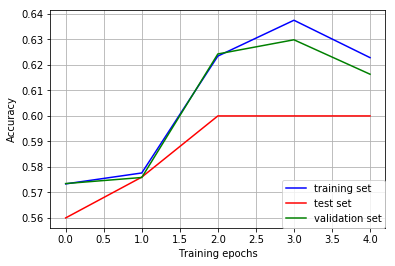

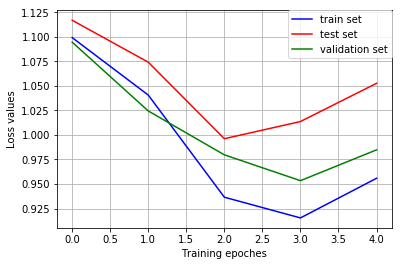

In [24]:
import matplotlib.pyplot as plt

plot_accuracy(acc_train, acc_test, acc_val)
plot_loss(loss_train, loss_test, loss_val)